# SUMMARY
I have been retained in May 2018 by a Private Equity firm looking to expand their real estate holdings into the New York City area. In particular, they are targeting Hudson County, NJ across the Hudson River to the city’s west. They want to know, quite simply, which areas should they invest in? Which areas will have the highest ROI in a 5 year investment horizon? 

The firm hired me to answer those questions. I used a Zillow dataset that contains almost every county in the United States to answer that question. The dataset contains thousands of zip codes from across the country with the mean home sale price for each month from April 1996 to April 2018. I narrowed the zip codes down to the 13 zip codes in Hudson County. The data is clearly non-stationary and transformations have no effect. Splitting the data into an 80-20 train-test split, I define predicted ROI percentage as the last predicted price-the last observed price/ the final observed price. That number is then multiplied by 100 to generate a percentage:

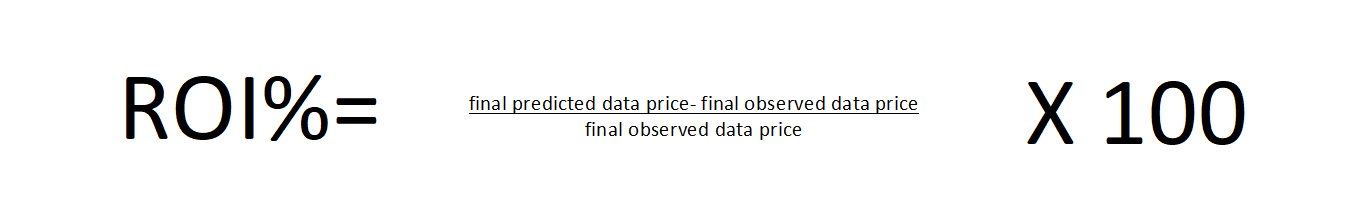

In the interest of time, I first employed pmdarima's auto.arima model to calculate the returns. However, the RMSEs were quite high so I turned to another model. Using a SARIMAX model, I obtained results with lower RMSEs.The top 5 zip codes were **07029, 07030, 07302, 07032, 07307**.


# BUSINESS UNDERSTANDING
The New York City area real estate market is perhaps the most valuable in the country and is among the most valuable in the world.  According to Statista(https://www.statista.com/statistics/815095/new-york-metro-area-population/) , the combined population of the New York metropolitan area is almost 20 million people. When people think of the New York area, they often only think of the city proper consisting of the 5 boroughs of the Bronx, Manhattan, Queens, Brooklyn, and Staten Island. The city's fabled real estate market is lucrative but it’s important for investors to look beyond the city. The city’s suburbs form an essential part of the area’s economic ecosystem. Hudson County, in particular, is tied to the city's economy. Wall Street firms house middle and back end operations across the Hudson River:https://www.nj.com/business/2013/07/is_new_jersey_now_wall_street.html. 

A Private Equity firm has hired me to find the zip codes with the highest ROI in the next 5 years. **This analysis will examine average home sale prices from every month from  April 1996 to April 2018 to forecast which zip codes have the highest ROI for the next 5 years. The projections are for 5 years because that is a typical investment horizon for a PE firm**.  


# DATA UNDERSTANDING
Zillow kindly provided average home sale data for each month from  April 1996 to August 2018 for almost every zip code in the United States. Obviously, that is an immense amount of data. There are some counties with missing information so it’s  best to do a narrow search when using this dataset and to understand its limitations. The dataset consists purely of the months and the prices. 

The evaluation metric I will use is **Root Mean Squared Error(RMSE)**. RMSE is best for this case because it will penalize large error terms and outliers.

# DATA PREPARATION
First, I will import relevant libraries and read the CSV file:


In [1]:
# Importing relevant libraries 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
import itertools
from pmdarima import auto_arima as pm

from pmdarima import model_selection
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

import statsmodels as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
%matplotlib inline

# Reading zillow csv
df = pd.read_csv('zillow_data.csv')


Showing the DataFrame. Let's also see the ROI% for each zip code.:

In [3]:
df
df['ROI%']= ((df['2018-04'])-(df['1996-04'])) /df['1996-04']*100
df

RegionID  RegionName                 City State              Metro  \
0         84654       60657              Chicago    IL            Chicago   
1         90668       75070             McKinney    TX  Dallas-Fort Worth   
2         91982       77494                 Katy    TX            Houston   
3         84616       60614              Chicago    IL            Chicago   
4         93144       79936              El Paso    TX            El Paso   
...         ...         ...                  ...   ...                ...   
14718     58333        1338             Ashfield    MA    Greenfield Town   
14719     59107        3293            Woodstock    NH          Claremont   
14720     75672       40404                Berea    KY           Richmond   
14721     93733       81225  Mount Crested Butte    CO                NaN   
14722     95851       89155             Mesquite    NV          Las Vegas   

      CountyName  SizeRank   1996-04   1996-05   1996-06  ...  2017-08  \
0           Cook         1  334200.0  335400.0  336500.0  ...  1007500   
1         Collin         2  235700.0  236900.0  236700.0  ...   310000   
2         Harris         3  210400.0  212200.0  212200.0  ...   320600   
3           Cook         4  498100.0  500900.0  503100.0  ...  1287700   
4        El Paso         5   77300.0   77300.0   77300.0  ...   119400   
...          ...       ...       ...       ...       ...  ...      ...   
14718   Franklin     14719   94600.0   94300.0   94000.0  ...   217700   
14719    Grafton     14720   92700.0   92500.0   92400.0  ...   208400   
14720    Madison     14721   57100.0   57300.0   57500.0  ...   122800   
14721   Gunnison     14722  191100.0  192400.0  193700.0  ...   671200   
14722      Clark     14723  176400.0  176300.0  176100.0  ...   336400   

       2017-09  2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  \
0      1007800  1009600  1013300  1018700  1024400  1030700  1033800  1030600   
1       312500   314100   315000   316600   318100   319600   321100   321800   
2       320200   320400   320800   321200   321200   323000   326900   329900   
3      1287400  1291500  1296600  1299000  1302700  1306400  1308500  1307000   
4       120000   120300   120300   120300   120300   120500   121000   121500   
...        ...      ...      ...      ...      ...      ...      ...      ...   
14718   218600   218500   218100   216400   213100   209800   209200   209300   
14719   212200   215200   214300   213100   213700   218300   222700   225800   
14720   124600   126700   128800   130600   131700   132500   133000   133400   
14721   682400   695600   695500   694700   706400   705300   681500   664400   
14722   339700   343800   346800   348900   350400   353000   356000   357200   

             ROI%  
0      208.378217  
1       36.529487  
2       56.796578  
3      162.397109  
4       57.179819  
...           ...  
14718  121.247357  
14719  143.581446  
14720  133.625219  
14721  247.671376  
14722  102.494331  

[14723 rows x 273 columns]

Here is a DataFrame for just Hudson County, NJ:

In [73]:
#Making DataFrames for Hudson County:

Hudson=df[df.CountyName == "Hudson"]
Hudson

RegionID  RegionName           City State     Metro CountyName  \
57       60545        7030        Hoboken    NJ  New York     Hudson   
187      60518        7002        Bayonne    NJ  New York     Hudson   
191      60639        7302    Jersey City    NJ  New York     Hudson   
214      60599        7093  West New York    NJ  New York     Hudson   
319      60594        7087     Union City    NJ  New York     Hudson   
519      60642        7305    Jersey City    NJ  New York     Hudson   
546      60560        7047   North Bergen    NJ  New York     Hudson   
660      60643        7306    Jersey City    NJ  New York     Hudson   
1737     60644        7307    Jersey City    NJ  New York     Hudson   
2989     60547        7032         Kearny    NJ  New York     Hudson   
5836     60600        7094       Secaucus    NJ  New York     Hudson   
6330     60593        7086      Weehawken    NJ  New York     Hudson   
6524     60544        7029       Harrison    NJ  New York     Hudson   

      SizeRank   1996-04   1996-05   1996-06  ...  2017-08  2017-09  2017-10  \
57          58  301600.0  302700.0  303800.0  ...  1803000  1818100  1836900   
187        188  145000.0  144500.0  143900.0  ...   324100   330900   339000   
191        192  137200.0  137800.0  138500.0  ...  1372300  1411000  1435900   
214        215  131700.0  131900.0  132100.0  ...   368200   376800   386200   
319        320  127300.0  127000.0  126700.0  ...   377500   386000   394700   
519        520  105200.0  104500.0  103800.0  ...   231200   234600   241100   
546        547  147200.0  146800.0  146400.0  ...   366200   368300   374100   
660        661  111400.0  111100.0  110900.0  ...   469800   475900   484000   
1737      1738  114300.0  114300.0  114400.0  ...   449000   458300   468100   
2989      2990  150300.0  150200.0  150100.0  ...   311900   316300   321800   
5836      5837  189600.0  189300.0  188900.0  ...   467500   473400   479100   
6330      6331  169700.0  169900.0  170000.0  ...   676200   695300   715100   
6524      6525  154200.0  154300.0  154400.0  ...   376600   376500   378200   

      2017-11  2017-12  2018-01  2018-02  2018-03  2018-04        ROI%  
57    1850100  1853500  1852200  1854400  1857600  1854300  514.820955  
187    347400   352800   355900   361500   368700   372900  157.172414  
191   1446300  1447800  1454900  1453900  1439500  1427300  940.306122  
214    392900   395100   395500   399400   407000   412700  213.363705  
319    403700   410500   415500   424000   437400   448900  252.631579  
519    251100   261600   268600   276000   286700   295100  180.513308  
546    383300   389900   391200   396500   409200   419100  184.714674  
660    495800   506700   510000   515300   531900   545500  389.676840  
1737   478200   487300   496000   510600   531900   546600  378.215223  
2989   327100   331300   334900   338100   341300   343200  128.343313  
5836   483500   486600   487300   492100   506500   520400  174.472574  
6330   730100   742600   749800   767700   804100   836100  392.692988  
6524   376500   373000   370300   370300   373100   377000  144.487678  

[13 rows x 273 columns]

Remember, I'm only looking for NY area counties so let's check and make sure sure that every zip code is in the NYC area.

In [5]:
#A check to see if there is a duplicate county name in another state.
def area_check(county):
    print(county.value_counts())

In [6]:
area_check(Hudson['State'])

NJ    13
Name: State, dtype: int64


Sucess!

Checking for any null values:

In [45]:
Hudson[Hudson.isnull().any(axis=1)] 

Empty DataFrame
Columns: [RegionID, RegionName, City, State, Metro, CountyName, SizeRank, 1996-04, 1996-05, 1996-06, 1996-07, 1996-08, 1996-09, 1996-10, 1996-11, 1996-12, 1997-01, 1997-02, 1997-03, 1997-04, 1997-05, 1997-06, 1997-07, 1997-08, 1997-09, 1997-10, 1997-11, 1997-12, 1998-01, 1998-02, 1998-03, 1998-04, 1998-05, 1998-06, 1998-07, 1998-08, 1998-09, 1998-10, 1998-11, 1998-12, 1999-01, 1999-02, 1999-03, 1999-04, 1999-05, 1999-06, 1999-07, 1999-08, 1999-09, 1999-10, 1999-11, 1999-12, 2000-01, 2000-02, 2000-03, 2000-04, 2000-05, 2000-06, 2000-07, 2000-08, 2000-09, 2000-10, 2000-11, 2000-12, 2001-01, 2001-02, 2001-03, 2001-04, 2001-05, 2001-06, 2001-07, 2001-08, 2001-09, 2001-10, 2001-11, 2001-12, 2002-01, 2002-02, 2002-03, 2002-04, 2002-05, 2002-06, 2002-07, 2002-08, 2002-09, 2002-10, 2002-11, 2002-12, 2003-01, 2003-02, 2003-03, 2003-04, 2003-05, 2003-06, 2003-07, 2003-08, 2003-09, 2003-10, 2003-11, 2003-12, ...]
Index: []

[0 rows x 273 columns]

Great, so there are no null values! Let's see the average return in Hudson County, NJ from 1996-2018.

In [9]:

print('Hudson ROI% from 1996-2018 is', Hudson['ROI%'].mean())


Hudson ROI% from 1996-2018 is 311.64702875969203


Ok, so the null values are gone. Now, I will concat the DataFrames.

* Maybe using ROI% over different periods. 
* Maybe focus on other areas as a hedge.
* Maybe focusing on price ranges. 
* Think about the business understanding.
* Better visualizations. --line charts, bar charts, check matplotlib for more. also folium--yelp--phase 1

Now let's check out the zip codes with the highest return:

In [10]:
#Sorting by ROI%.
Hudson.sort_values(["ROI%"], ascending=False, inplace=True)
Hudson

RegionID  RegionName           City State     Metro CountyName  \
191      60639        7302    Jersey City    NJ  New York     Hudson   
57       60545        7030        Hoboken    NJ  New York     Hudson   
6330     60593        7086      Weehawken    NJ  New York     Hudson   
660      60643        7306    Jersey City    NJ  New York     Hudson   
1737     60644        7307    Jersey City    NJ  New York     Hudson   
319      60594        7087     Union City    NJ  New York     Hudson   
214      60599        7093  West New York    NJ  New York     Hudson   
546      60560        7047   North Bergen    NJ  New York     Hudson   
519      60642        7305    Jersey City    NJ  New York     Hudson   
5836     60600        7094       Secaucus    NJ  New York     Hudson   
187      60518        7002        Bayonne    NJ  New York     Hudson   
6524     60544        7029       Harrison    NJ  New York     Hudson   
2989     60547        7032         Kearny    NJ  New York     Hudson   

      SizeRank   1996-04   1996-05   1996-06  ...  2017-08  2017-09  2017-10  \
191        192  137200.0  137800.0  138500.0  ...  1372300  1411000  1435900   
57          58  301600.0  302700.0  303800.0  ...  1803000  1818100  1836900   
6330      6331  169700.0  169900.0  170000.0  ...   676200   695300   715100   
660        661  111400.0  111100.0  110900.0  ...   469800   475900   484000   
1737      1738  114300.0  114300.0  114400.0  ...   449000   458300   468100   
319        320  127300.0  127000.0  126700.0  ...   377500   386000   394700   
214        215  131700.0  131900.0  132100.0  ...   368200   376800   386200   
546        547  147200.0  146800.0  146400.0  ...   366200   368300   374100   
519        520  105200.0  104500.0  103800.0  ...   231200   234600   241100   
5836      5837  189600.0  189300.0  188900.0  ...   467500   473400   479100   
187        188  145000.0  144500.0  143900.0  ...   324100   330900   339000   
6524      6525  154200.0  154300.0  154400.0  ...   376600   376500   378200   
2989      2990  150300.0  150200.0  150100.0  ...   311900   316300   321800   

      2017-11  2017-12  2018-01  2018-02  2018-03  2018-04        ROI%  
191   1446300  1447800  1454900  1453900  1439500  1427300  940.306122  
57    1850100  1853500  1852200  1854400  1857600  1854300  514.820955  
6330   730100   742600   749800   767700   804100   836100  392.692988  
660    495800   506700   510000   515300   531900   545500  389.676840  
1737   478200   487300   496000   510600   531900   546600  378.215223  
319    403700   410500   415500   424000   437400   448900  252.631579  
214    392900   395100   395500   399400   407000   412700  213.363705  
546    383300   389900   391200   396500   409200   419100  184.714674  
519    251100   261600   268600   276000   286700   295100  180.513308  
5836   483500   486600   487300   492100   506500   520400  174.472574  
187    347400   352800   355900   361500   368700   372900  157.172414  
6524   376500   373000   370300   370300   373100   377000  144.487678  
2989   327100   331300   334900   338100   341300   343200  128.343313  

[13 rows x 273 columns]

Here are the top 5 returners:

In [11]:
#Top 5 returners
Hudson.head()

RegionID  RegionName         City State     Metro CountyName  SizeRank  \
191      60639        7302  Jersey City    NJ  New York     Hudson       192   
57       60545        7030      Hoboken    NJ  New York     Hudson        58   
6330     60593        7086    Weehawken    NJ  New York     Hudson      6331   
660      60643        7306  Jersey City    NJ  New York     Hudson       661   
1737     60644        7307  Jersey City    NJ  New York     Hudson      1738   

       1996-04   1996-05   1996-06  ...  2017-08  2017-09  2017-10  2017-11  \
191   137200.0  137800.0  138500.0  ...  1372300  1411000  1435900  1446300   
57    301600.0  302700.0  303800.0  ...  1803000  1818100  1836900  1850100   
6330  169700.0  169900.0  170000.0  ...   676200   695300   715100   730100   
660   111400.0  111100.0  110900.0  ...   469800   475900   484000   495800   
1737  114300.0  114300.0  114400.0  ...   449000   458300   468100   478200   

      2017-12  2018-01  2018-02  2018-03  2018-04        ROI%  
191   1447800  1454900  1453900  1439500  1427300  940.306122  
57    1853500  1852200  1854400  1857600  1854300  514.820955  
6330   742600   749800   767700   804100   836100  392.692988  
660    506700   510000   515300   531900   545500  389.676840  
1737   487300   496000   510600   531900   546600  378.215223  

[5 rows x 273 columns]

The 5 highest ROI% zip codes for the dataset are all right on the Hudson River.

# Modeling

First, I will emply a function that will transform the dataset into a longform DataFrame where each zip code represents a column and each date represents a month:

In [12]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

Before I melt the data, I need to eliminate any columns with string values so I have to eliminate the ROI% column:

In [13]:
Hudson.drop('ROI%', axis=1, inplace=True)

Metling the data on the NYC suburbs:

In [15]:
Suburbs = pd.DataFrame()
for i in Hudson['RegionName']:
    x = melt_data(Hudson[Hudson['RegionName'] == i])  
    Suburbs = pd.concat([Suburbs, x], axis=1)
    Suburbs.rename(columns = {'value':i}, inplace = True)
Suburbs

7302       7030      7086      7306      7307      7087  \
time                                                                       
1996-04-01   137200.0   301600.0  169700.0  111400.0  114300.0  127300.0   
1996-05-01   137800.0   302700.0  169900.0  111100.0  114300.0  127000.0   
1996-06-01   138500.0   303800.0  170000.0  110900.0  114400.0  126700.0   
1996-07-01   139100.0   304800.0  170100.0  110600.0  114500.0  126400.0   
1996-08-01   139600.0   305800.0  170200.0  110300.0  114800.0  126100.0   
...               ...        ...       ...       ...       ...       ...   
2017-12-01  1447800.0  1853500.0  742600.0  506700.0  487300.0  410500.0   
2018-01-01  1454900.0  1852200.0  749800.0  510000.0  496000.0  415500.0   
2018-02-01  1453900.0  1854400.0  767700.0  515300.0  510600.0  424000.0   
2018-03-01  1439500.0  1857600.0  804100.0  531900.0  531900.0  437400.0   
2018-04-01  1427300.0  1854300.0  836100.0  545500.0  546600.0  448900.0   

                7093      7047      7305      7094      7002      7029  \
time                                                                     
1996-04-01  131700.0  147200.0  105200.0  189600.0  145000.0  154200.0   
1996-05-01  131900.0  146800.0  104500.0  189300.0  144500.0  154300.0   
1996-06-01  132100.0  146400.0  103800.0  188900.0  143900.0  154400.0   
1996-07-01  132300.0  146000.0  103100.0  188500.0  143300.0  154400.0   
1996-08-01  132500.0  145800.0  102600.0  188100.0  142800.0  154500.0   
...              ...       ...       ...       ...       ...       ...   
2017-12-01  395100.0  389900.0  261600.0  486600.0  352800.0  373000.0   
2018-01-01  395500.0  391200.0  268600.0  487300.0  355900.0  370300.0   
2018-02-01  399400.0  396500.0  276000.0  492100.0  361500.0  370300.0   
2018-03-01  407000.0  409200.0  286700.0  506500.0  368700.0  373100.0   
2018-04-01  412700.0  419100.0  295100.0  520400.0  372900.0  377000.0   

                7032  
time                  
1996-04-01  150300.0  
1996-05-01  150200.0  
1996-06-01  150100.0  
1996-07-01  150200.0  
1996-08-01  150200.0  
...              ...  
2017-12-01  331300.0  
2018-01-01  334900.0  
2018-02-01  338100.0  
2018-03-01  341300.0  
2018-04-01  343200.0  

[265 rows x 13 columns]

In [16]:
# Null Check
Suburbs[Suburbs.isnull().any(axis=1)] 

Empty DataFrame
Columns: [7302, 7030, 7086, 7306, 7307, 7087, 7093, 7047, 7305, 7094, 7002, 7029, 7032]
Index: []

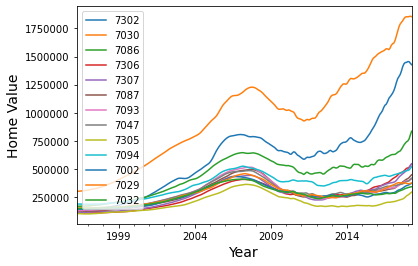

In [17]:
# Examining the plots for each zip code
Suburbs.plot()
plt.xlabel('Year',fontsize=14)
plt.ylabel('Home Value',fontsize=14)
plt.ticklabel_format(axis='y',style='plain',useOffset=False);

Judging by looks alone, the data is not stationary for any.

## Train-Test Split

In [18]:
#Making a test train split. First, I am calculating the training set length:

f'{265*.8} months will be in training set'

'212.0 months will be in training set'

In [19]:
# Here is the test set length:
f'{265*.2} months will be in test set'

'53.0 months will be in test set'

In [20]:


# Train test split with the first 212 out 265 months as training data.
train_1 = Suburbs.iloc[:212, :]
# The last 60 months, 5 years, will be used as test data.
test_1 = Suburbs.iloc[212:, :]

Here's the train data:

In [21]:
# Train DataFrame
train_1

7302       7030      7086      7306      7307      7087  \
time                                                                      
1996-04-01  137200.0   301600.0  169700.0  111400.0  114300.0  127300.0   
1996-05-01  137800.0   302700.0  169900.0  111100.0  114300.0  127000.0   
1996-06-01  138500.0   303800.0  170000.0  110900.0  114400.0  126700.0   
1996-07-01  139100.0   304800.0  170100.0  110600.0  114500.0  126400.0   
1996-08-01  139600.0   305800.0  170200.0  110300.0  114800.0  126100.0   
...              ...        ...       ...       ...       ...       ...   
2013-07-01  709200.0  1213800.0  525100.0  270500.0  261300.0  254100.0   
2013-08-01  722500.0  1230600.0  527900.0  270800.0  260200.0  255400.0   
2013-09-01  730500.0  1244400.0  526000.0  272500.0  261400.0  255800.0   
2013-10-01  736500.0  1255600.0  525500.0  271100.0  263000.0  255100.0   
2013-11-01  738200.0  1257100.0  524300.0  267300.0  263300.0  252800.0   

                7093      7047      7305      7094      7002      7029  \
time                                                                     
1996-04-01  131700.0  147200.0  105200.0  189600.0  145000.0  154200.0   
1996-05-01  131900.0  146800.0  104500.0  189300.0  144500.0  154300.0   
1996-06-01  132100.0  146400.0  103800.0  188900.0  143900.0  154400.0   
1996-07-01  132300.0  146000.0  103100.0  188500.0  143300.0  154400.0   
1996-08-01  132500.0  145800.0  102600.0  188100.0  142800.0  154500.0   
...              ...       ...       ...       ...       ...       ...   
2013-07-01  248900.0  290600.0  167200.0  395300.0  258900.0  258400.0   
2013-08-01  250600.0  292400.0  170000.0  397100.0  260500.0  263100.0   
2013-09-01  252700.0  290100.0  170800.0  397500.0  262200.0  265600.0   
2013-10-01  254200.0  285500.0  169900.0  398300.0  261400.0  267800.0   
2013-11-01  254600.0  281600.0  168900.0  398700.0  259900.0  269700.0   

                7032  
time                  
1996-04-01  150300.0  
1996-05-01  150200.0  
1996-06-01  150100.0  
1996-07-01  150200.0  
1996-08-01  150200.0  
...              ...  
2013-07-01  256400.0  
2013-08-01  258000.0  
2013-09-01  260700.0  
2013-10-01  262600.0  
2013-11-01  264000.0  

[212 rows x 13 columns]

Here's the test data:

In [22]:
# Test Data
test_1

7302       7030      7086      7306      7307      7087  \
time                                                                       
2013-12-01   739900.0  1253500.0  519000.0  263900.0  264600.0  250400.0   
2014-01-01   747500.0  1258800.0  514100.0  261200.0  267700.0  250600.0   
2014-02-01   761300.0  1277000.0  512200.0  260200.0  272500.0  253900.0   
2014-03-01   774100.0  1295100.0  508000.0  261100.0  278500.0  258600.0   
2014-04-01   778700.0  1304900.0  510100.0  264400.0  284300.0  263200.0   
2014-05-01   771300.0  1304200.0  523700.0  268500.0  288300.0  264800.0   
2014-06-01   759800.0  1300600.0  538600.0  273100.0  292000.0  264700.0   
2014-07-01   753800.0  1302800.0  542900.0  278600.0  297200.0  265500.0   
2014-08-01   747700.0  1308900.0  541100.0  285300.0  302500.0  268500.0   
2014-09-01   742100.0  1314500.0  541600.0  289600.0  304700.0  272100.0   
2014-10-01   738900.0  1323700.0  540600.0  292600.0  306700.0  277000.0   
2014-11-01   736900.0  1332100.0  532900.0  295800.0  310300.0  282200.0   
2014-12-01   737500.0  1342200.0  522500.0  299500.0  312000.0  287000.0   
2015-01-01   742500.0  1350500.0  517600.0  302200.0  310500.0  289500.0   
2015-02-01   747700.0  1351500.0  519400.0  303300.0  306900.0  289200.0   
2015-03-01   753800.0  1352400.0  526500.0  304800.0  303400.0  288500.0   
2015-04-01   767500.0  1364100.0  527400.0  307900.0  302100.0  289400.0   
2015-05-01   784100.0  1380100.0  523500.0  310600.0  303900.0  293700.0   
2015-06-01   799000.0  1399300.0  524800.0  313500.0  308100.0  300300.0   
2015-07-01   814800.0  1422200.0  533000.0  319000.0  312800.0  305900.0   
2015-08-01   834600.0  1446500.0  540500.0  325800.0  316300.0  307900.0   
2015-09-01   853700.0  1471600.0  541200.0  332100.0  319600.0  308100.0   
2015-10-01   871100.0  1487500.0  537600.0  338200.0  321200.0  307000.0   
2015-11-01   890800.0  1495800.0  542500.0  342000.0  321100.0  305400.0   
2015-12-01   913900.0  1505500.0  557900.0  343700.0  324100.0  304000.0   
2016-01-01   939700.0  1518200.0  572900.0  346700.0  331700.0  303100.0   
2016-02-01   964400.0  1526600.0  580000.0  349500.0  340100.0  303100.0   
2016-03-01   986100.0  1533300.0  581000.0  350700.0  345900.0  304500.0   
2016-04-01  1001000.0  1540500.0  578600.0  353500.0  350700.0  306300.0   
2016-05-01  1019000.0  1546500.0  579300.0  358800.0  354700.0  308100.0   
2016-06-01  1047500.0  1550800.0  585800.0  364800.0  358200.0  309800.0   
2016-07-01  1067200.0  1559400.0  596900.0  370700.0  362600.0  312700.0   
2016-08-01  1076600.0  1568800.0  604300.0  375500.0  367600.0  315300.0   
2016-09-01  1098400.0  1567000.0  609500.0  379500.0  371000.0  318000.0   
2016-10-01  1127000.0  1561300.0  614800.0  385800.0  374500.0  320900.0   
2016-11-01  1142100.0  1574500.0  621600.0  395400.0  377000.0  323100.0   
2016-12-01  1157100.0  1600300.0  626800.0  405300.0  378300.0  324500.0   
2017-01-01  1174700.0  1613300.0  629600.0  413900.0  380400.0  325900.0   
2017-02-01  1196900.0  1619700.0  629700.0  421200.0  383700.0  328100.0   
2017-03-01  1229500.0  1644300.0  631400.0  427700.0  388900.0  333700.0   
2017-04-01  1269300.0  1684300.0  639100.0  435300.0  399800.0  343400.0   
2017-05-01  1302500.0  1726200.0  649000.0  447100.0  414800.0  352100.0   
2017-06-01  1321900.0  1763200.0  655000.0  458000.0  428400.0  358700.0   
2017-07-01  1340200.0  1789100.0  661200.0  465400.0  439500.0  367000.0   
2017-08-01  1372300.0  1803000.0  676200.0  469800.0  449000.0  377500.0   
2017-09-01  1411000.0  1818100.0  695300.0  475900.0  458300.0  386000.0   
2017-10-01  1435900.0  1836900.0  715100.0  484000.0  468100.0  394700.0   
2017-11-01  1446300.0  1850100.0  730100.0  495800.0  478200.0  403700.0   
2017-12-01  1447800.0  1853500.0  742600.0  506700.0  487300.0  410500.0   
2018-01-01  1454900.0  1852200.0  749800.0  510000.0  496000.0  415500.0   
2018-02-01  1453900.0  1854400.0  767700.0  515300.0  510600.0  4

Here is a function that test for stationarity:

In [23]:
#Function to check for stationarity for each zipcode. 
def dftest_stationarity(data):
    for x in data:
        # Check to see if the p-value ≤ .05. If so, it returns the the stationary zipcodes with associated values.
        if  adfuller(data[x])[1] <=.05: 
            return(x, adfuller(data[x])[0:6])
        

Let's check for stationarity in the Suburbs dataset:

In [24]:
dftest_stationarity(Suburbs)

(7093,
 (-2.8859795010040825,
  0.04700285173064798,
  13,
  251,
  {'1%': -3.4566744514553016,
   '5%': -2.8731248767783426,
   '10%': -2.5729436702592023},
  4081.2791763890964))

Only 07093 is stationary.

Now, for the training set:

In [25]:
dftest_stationarity(train_1)

None are stationary. Let's try differencing the values to see if that makaes any difference:

In [26]:
#Differenced data of 1 month
train_1.diff()[1:]

7302     7030    7086    7306    7307    7087    7093    7047  \
time                                                                           
1996-05-01    600.0   1100.0   200.0  -300.0     0.0  -300.0   200.0  -400.0   
1996-06-01    700.0   1100.0   100.0  -200.0   100.0  -300.0   200.0  -400.0   
1996-07-01    600.0   1000.0   100.0  -300.0   100.0  -300.0   200.0  -400.0   
1996-08-01    500.0   1000.0   100.0  -300.0   300.0  -300.0   200.0  -200.0   
1996-09-01    500.0   1000.0   200.0  -300.0   400.0  -200.0   200.0     0.0   
...             ...      ...     ...     ...     ...     ...     ...     ...   
2013-07-01  18400.0  20000.0  8900.0 -2000.0   600.0  2600.0   500.0  3800.0   
2013-08-01  13300.0  16800.0  2800.0   300.0 -1100.0  1300.0  1700.0  1800.0   
2013-09-01   8000.0  13800.0 -1900.0  1700.0  1200.0   400.0  2100.0 -2300.0   
2013-10-01   6000.0  11200.0  -500.0 -1400.0  1600.0  -700.0  1500.0 -4600.0   
2013-11-01   1700.0   1500.0 -1200.0 -3800.0   300.0 -2300.0   400.0 -3900.0   

              7305    7094    7002    7029    7032  
time                                                
1996-05-01  -700.0  -300.0  -500.0   100.0  -100.0  
1996-06-01  -700.0  -400.0  -600.0   100.0  -100.0  
1996-07-01  -700.0  -400.0  -600.0     0.0   100.0  
1996-08-01  -500.0  -400.0  -500.0   100.0     0.0  
1996-09-01  -500.0  -300.0  -400.0     0.0   200.0  
...            ...     ...     ...     ...     ...  
2013-07-01  2200.0  4200.0  -900.0  6800.0 -1300.0  
2013-08-01  2800.0  1800.0  1600.0  4700.0  1600.0  
2013-09-01   800.0   400.0  1700.0  2500.0  2700.0  
2013-10-01  -900.0   800.0  -800.0  2200.0  1900.0  
2013-11-01 -1000.0   400.0 -1500.0  1900.0  1400.0  

[211 rows x 13 columns]

In [27]:
dftest_stationarity(train_1.diff()[1:])

None of the zip codes are stationary. Maybe the square root will be more stationary?

In [28]:
#Creating square root of training data
train_sqrt = np.sqrt(train_1)
train_sqrt

7302         7030        7086        7306        7307  \
time                                                                      
1996-04-01  370.405184   549.181209  411.946598  333.766385  338.082830   
1996-05-01  371.214224   550.181788  412.189277  333.316666  338.082830   
1996-06-01  372.155881   551.180551  412.310563  333.016516  338.230691   
1996-07-01  372.961124   552.086950  412.431813  332.565783  338.378486   
1996-08-01  373.630834   552.991863  412.553027  332.114438  338.821487   
...                ...          ...         ...         ...         ...   
2013-07-01  842.140131  1101.725919  724.637841  520.096145  511.175117   
2013-08-01  850.000000  1109.324119  726.567271  520.384473  510.098030   
2013-09-01  854.692927  1115.526781  725.258575  522.015325  511.272921   
2013-10-01  858.195782  1120.535586  724.913788  520.672642  512.835256   
2013-11-01  859.185661  1121.204709  724.085630  517.010638  513.127664   

                  7087        7093        7047        7305        7094  \
time                                                                     
1996-04-01  356.791255  362.904946  383.666522  324.345495  435.430821   
1996-05-01  356.370594  363.180396  383.144881  323.264598  435.086198   
1996-06-01  355.949435  363.455637  382.622529  322.180074  434.626276   
1996-07-01  355.527777  363.730670  382.099463  321.091887  434.165867   
1996-08-01  355.105618  364.005494  381.837662  320.312348  433.704969   
...                ...         ...         ...         ...         ...   
2013-07-01  504.083326  498.898787  539.073279  408.900966  628.728876   
2013-08-01  505.371151  500.599640  540.740233  412.310563  630.158710   
2013-09-01  505.766745  502.692749  538.609320  413.279566  630.476011   
2013-10-01  505.074252  504.182507  534.322000  412.189277  631.110133   
2013-11-01  502.792204  504.579032  530.659966  410.974452  631.426955   

                  7002        7029        7032  
time                                            
1996-04-01  380.788655  392.683078  387.685439  
1996-05-01  380.131556  392.810387  387.556448  
1996-06-01  379.341535  392.937654  387.427413  
1996-07-01  378.549865  392.937654  387.556448  
1996-08-01  377.888873  393.064880  387.556448  
...                ...         ...         ...  
2013-07-01  508.822169  508.330601  506.359556  
2013-08-01  510.392006  512.932744  507.937004  
2013-09-01  512.054685  515.363949  510.587896  
2013-10-01  511.272921  517.493961  512.445119  
2013-11-01  509.803884  519.326487  513.809303  

[212 rows x 13 columns]

Now, let's see if using the square root values makes the data more stationary:

In [29]:
dftest_stationarity(train_sqrt)

No progress, perhaps a logarithmic transformation will make the data more stationary?


In [30]:
# Log transformed data
train_log = np.log(train_1)
train_log.head(3)

7302       7030       7086       7306       7307       7087  \
time                                                                           
1996-04-01  11.829195  12.616857  12.041787  11.620883  11.646582  11.754302   
1996-05-01  11.833559  12.620497  12.042965  11.618186  11.646582  11.751942   
1996-06-01  11.838626  12.624125  12.043554  11.616384  11.647456  11.749577   

                 7093       7047       7305       7094       7002       7029  \
time                                                                           
1996-04-01  11.788282  11.899547  11.563619  12.152672  11.884489  11.946006   
1996-05-01  11.789799  11.896826  11.556942  12.151088  11.881035  11.946654   
1996-06-01  11.791314  11.894098  11.550221  12.148973  11.876874  11.947302   

                 7032  
time                   
1996-04-01  11.920389  
1996-05-01  11.919723  
1996-06-01  11.919057

In [31]:
dftest_stationarity(train_log)

(7087,
 (-2.952981423049992,
  0.039524798462209514,
  15,
  196,
  {'1%': -3.464161278384219,
   '5%': -2.876401960790147,
   '10%': -2.5746921001665974},
  -1719.8124441748519))

No, the log transfomation did not significantly make the data more stationary since only 1 zip code is stationary.

**So, far none of these methods have yielded a significant amount of stationary data. Therefore, it's best to accept the data's seasonality. I am going to start with pmdarima's auto.arima model because it is fast**.

However, before I use auto_arima, I want to add rows to my DataFrame so I can graph the predictions. First, I have to make a copy of 'Suburbs', then I will add the rows, then I will make it into a DataFrame. Lastly, I must take the DataFrame's index and convert it into an array.

In [32]:
#For Loop to get 60 more rows that will be used for subsequent 5 years
burbs_copy=Suburbs.copy(deep=True)
for i in range(1,61):
    idx = burbs_copy.tail(1).index[0] + pd.Timedelta(days=(365/12))
    burbs_copy.loc[idx] = 0
#Making the list into a DataFrame, making the index into an array

burbs_2=pd.DataFrame(burbs_copy)
#Make the index into an array
date_list=burbs_2.index.to_numpy()
dates=pd.to_datetime(date_list, format='%Y-%d-%m')
dates[265:]

DatetimeIndex(['2018-05-01 10:00:00', '2018-05-31 20:00:00',
               '2018-07-01 06:00:00', '2018-07-31 16:00:00',
               '2018-08-31 02:00:00', '2018-09-30 12:00:00',
               '2018-10-30 22:00:00', '2018-11-30 08:00:00',
               '2018-12-30 18:00:00', '2019-01-30 04:00:00',
               '2019-03-01 14:00:00', '2019-04-01 00:00:00',
               '2019-05-01 10:00:00', '2019-05-31 20:00:00',
               '2019-07-01 06:00:00', '2019-07-31 16:00:00',
               '2019-08-31 02:00:00', '2019-09-30 12:00:00',
               '2019-10-30 22:00:00', '2019-11-30 08:00:00',
               '2019-12-30 18:00:00', '2020-01-30 04:00:00',
               '2020-02-29 14:00:00', '2020-03-31 00:00:00',
               '2020-04-30 10:00:00', '2020-05-30 20:00:00',
               '2020-06-30 06:00:00', '2020-07-30 16:00:00',
               '2020-08-30 02:00:00', '2020-09-29 12:00:00',
               '2020-10-29 22:00:00', '2020-11-29 08:00:00',
               '2020-12-

Next, I will import a few time functions because it's practical to know how long the it will take to do auto_arima on 201 zipcodes:

In [33]:
#importing time functions
import timeit
import time


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  212
Model:               SARIMAX(1, 2, 0)   Log Likelihood               -1980.156
Date:                Fri, 02 Sep 2022   AIC                           3964.313
Time:                        13:19:49   BIC                           3971.007
Sample:                             0   HQIC                          3967.019
                                - 212                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0509      0.013      3.885      0.000       0.025       0.077
sigma2      9.018e+06   6.49e-11   1.39e+17      0.000    9.02e+06    9.02e+06
Ljung-Box (L1) (Q):                  26.89   Jarque-

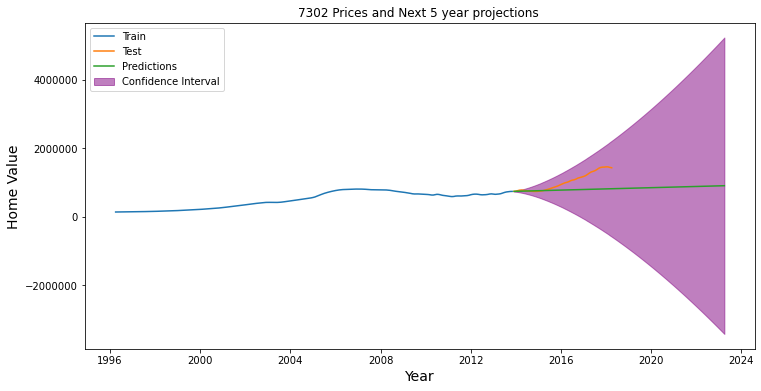

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  212
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2158.473
Date:                Fri, 02 Sep 2022   AIC                           4324.946
Time:                        13:19:52   BIC                           4338.354
Sample:                             0   HQIC                          4330.366
                                - 212                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    341.2474    126.801      2.691      0.007      92.721     589.773
ar.L1          0.9007      0.030     30.299      0.000       0.842       0.959
ma.L1         -0.8457      0.035    -24.396      0.0

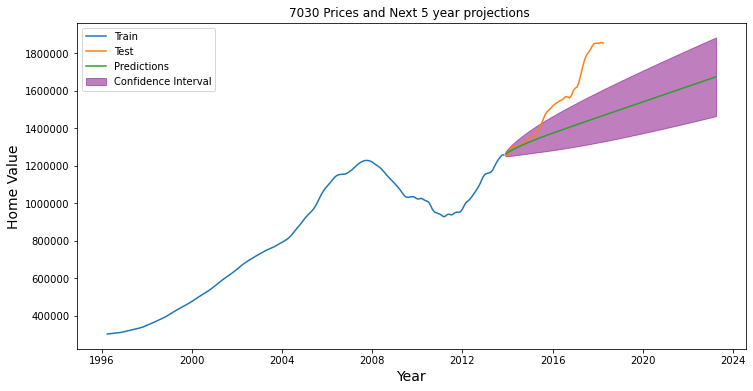

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  212
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1914.720
Date:                Fri, 02 Sep 2022   AIC                           3831.440
Time:                        13:19:53   BIC                           3834.788
Sample:                             0   HQIC                          3832.794
                                - 212                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.819e+06   1.76e+05     27.448      0.000    4.47e+06    5.16e+06
Ljung-Box (L1) (Q):                  23.39   Jarque-Bera (JB):              1301.79
Prob(Q):                              0.00   Pr

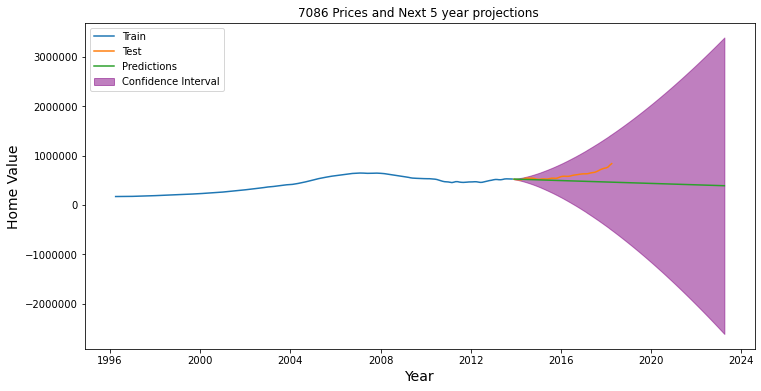

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  212
Model:               SARIMAX(3, 2, 0)   Log Likelihood               -1757.533
Date:                Fri, 02 Sep 2022   AIC                           3523.066
Time:                        13:19:57   BIC                           3536.455
Sample:                             0   HQIC                          3528.479
                                - 212                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0125      0.014      0.867      0.386      -0.016       0.041
ar.L2         -0.0462      0.017     -2.670      0.008      -0.080      -0.012
ar.L3         -0.0476      0.010     -4.664      0.0

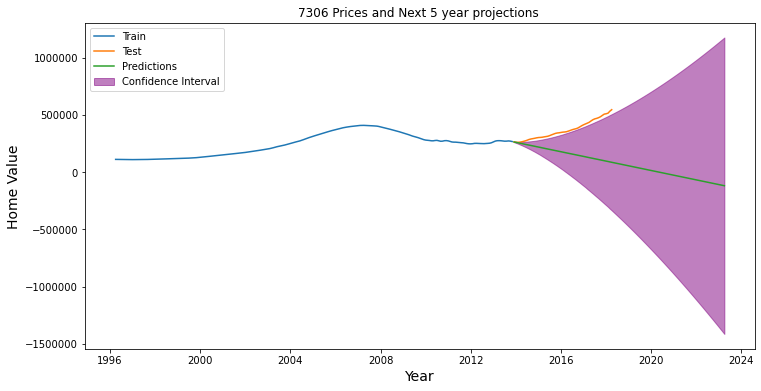

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  212
Model:               SARIMAX(0, 2, 1)   Log Likelihood               -1691.074
Date:                Fri, 02 Sep 2022   AIC                           3386.149
Time:                        13:19:58   BIC                           3392.843
Sample:                             0   HQIC                          3388.855
                                - 212                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0336      0.013      2.586      0.010       0.008       0.059
sigma2      5.702e+05   2.49e+04     22.931      0.000    5.22e+05    6.19e+05
Ljung-Box (L1) (Q):                  23.69   Jarque-

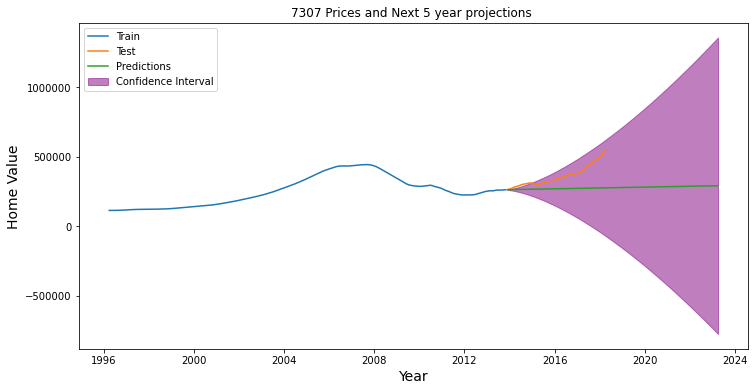

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  212
Model:               SARIMAX(0, 2, 1)   Log Likelihood               -1780.329
Date:                Fri, 02 Sep 2022   AIC                           3564.658
Time:                        13:19:59   BIC                           3571.352
Sample:                             0   HQIC                          3567.364
                                - 212                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0278      0.013      2.165      0.030       0.003       0.053
sigma2      1.341e+06   6.42e+04     20.895      0.000    1.22e+06    1.47e+06
Ljung-Box (L1) (Q):                  23.58   Jarque-

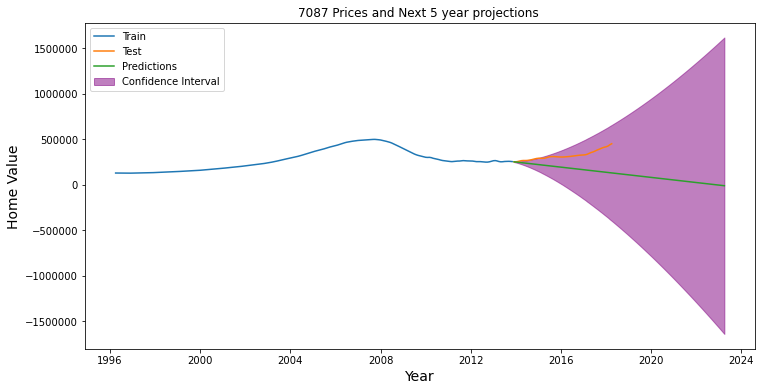

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  212
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1794.994
Date:                Fri, 02 Sep 2022   AIC                           3591.989
Time:                        13:20:00   BIC                           3595.336
Sample:                             0   HQIC                          3593.342
                                - 212                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.541e+06    5.2e+04     29.618      0.000    1.44e+06    1.64e+06
Ljung-Box (L1) (Q):                  18.00   Jarque-Bera (JB):              1814.57
Prob(Q):                              0.00   Pr

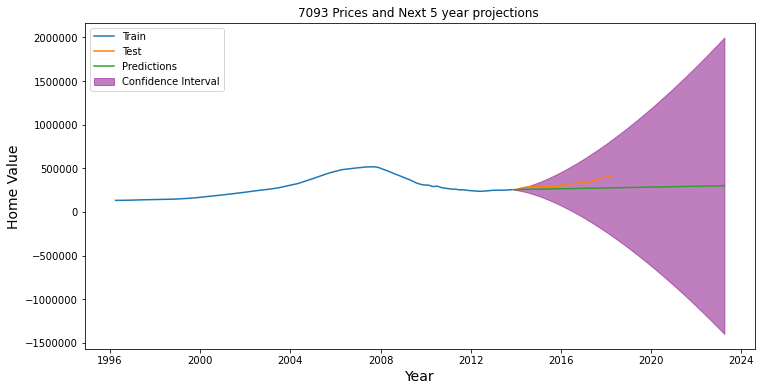

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  212
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1795.357
Date:                Fri, 02 Sep 2022   AIC                           3592.714
Time:                        13:20:00   BIC                           3596.061
Sample:                             0   HQIC                          3594.067
                                - 212                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.546e+06   6.96e+04     22.212      0.000    1.41e+06    1.68e+06
Ljung-Box (L1) (Q):                  31.60   Jarque-Bera (JB):               457.31
Prob(Q):                              0.00   Pr

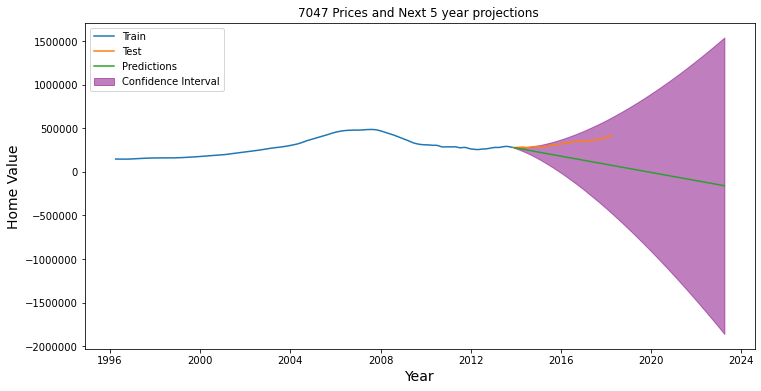

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  212
Model:               SARIMAX(0, 2, 1)   Log Likelihood               -1699.553
Date:                Fri, 02 Sep 2022   AIC                           3403.105
Time:                        13:20:01   BIC                           3409.799
Sample:                             0   HQIC                          3405.811
                                - 212                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0451      0.012      3.699      0.000       0.021       0.069
sigma2      6.146e+05   3.06e+04     20.058      0.000    5.55e+05    6.75e+05
Ljung-Box (L1) (Q):                  26.20   Jarque-

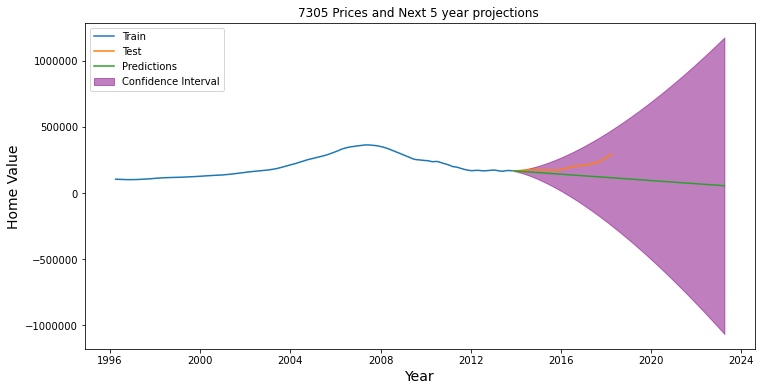

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  212
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1764.259
Date:                Fri, 02 Sep 2022   AIC                           3530.518
Time:                        13:20:02   BIC                           3533.865
Sample:                             0   HQIC                          3531.871
                                - 212                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       1.15e+06   6.67e+04     17.251      0.000    1.02e+06    1.28e+06
Ljung-Box (L1) (Q):                  40.31   Jarque-Bera (JB):               112.22
Prob(Q):                              0.00   Pr

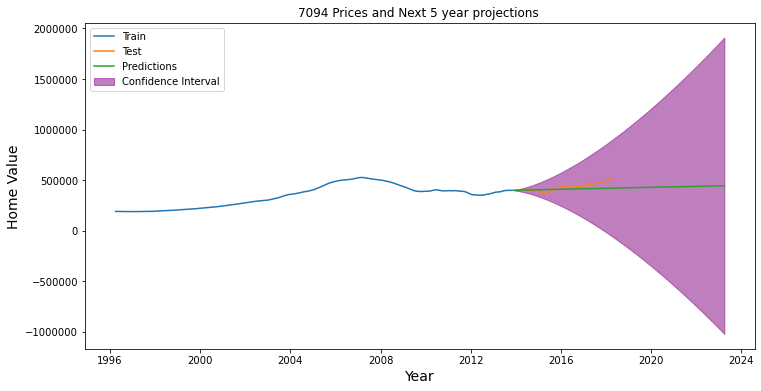

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  212
Model:               SARIMAX(0, 2, 1)   Log Likelihood               -1699.929
Date:                Fri, 02 Sep 2022   AIC                           3403.859
Time:                        13:20:03   BIC                           3410.553
Sample:                             0   HQIC                          3406.565
                                - 212                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0272      0.012      2.331      0.020       0.004       0.050
sigma2      6.213e+05      3e+04     20.714      0.000    5.63e+05     6.8e+05
Ljung-Box (L1) (Q):                  30.56   Jarque-

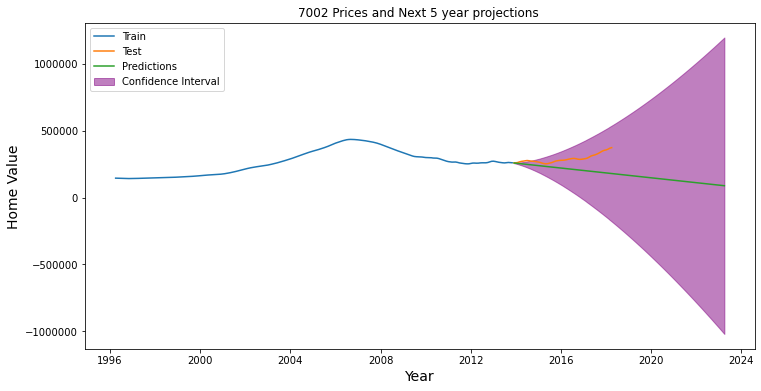

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  212
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1801.240
Date:                Fri, 02 Sep 2022   AIC                           3604.481
Time:                        13:20:04   BIC                           3607.828
Sample:                             0   HQIC                          3605.834
                                - 212                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.635e+06    8.5e+04     19.228      0.000    1.47e+06     1.8e+06
Ljung-Box (L1) (Q):                  16.59   Jarque-Bera (JB):               211.35
Prob(Q):                              0.00   Pr

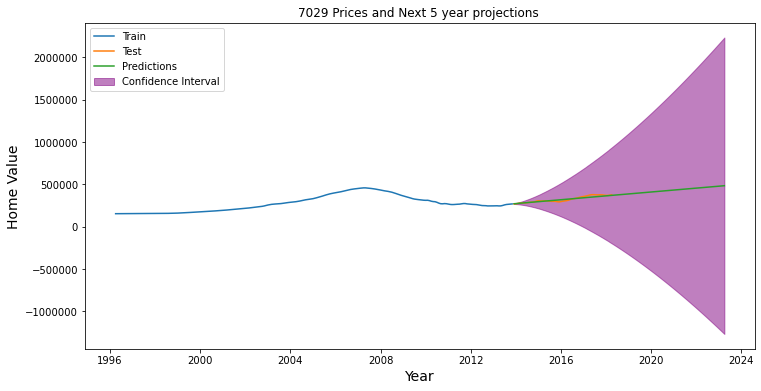

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  212
Model:               SARIMAX(0, 2, 1)   Log Likelihood               -1684.318
Date:                Fri, 02 Sep 2022   AIC                           3372.636
Time:                        13:20:05   BIC                           3379.330
Sample:                             0   HQIC                          3375.342
                                - 212                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0244      0.012      2.074      0.038       0.001       0.047
sigma2      5.359e+05   2.24e+04     23.902      0.000    4.92e+05     5.8e+05
Ljung-Box (L1) (Q):                  31.37   Jarque-

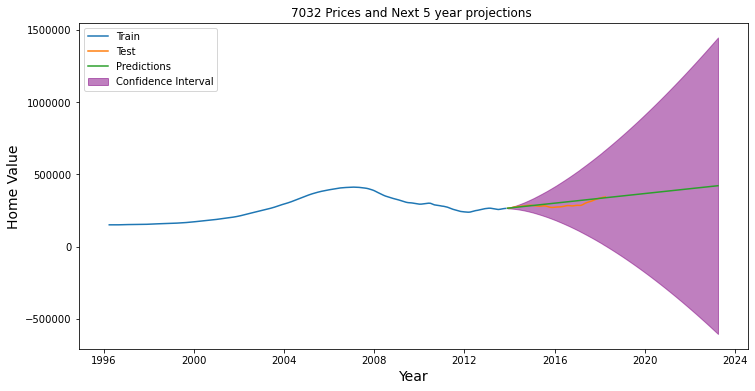

Wall time: 17.9 s


In [34]:
%%time

#This is an empty dictionary that will later hold our ROI% values.
ROI_dict={}
for area in Suburbs:
    #80/20 split for each zipcode
    train, test = model_selection.train_test_split(Suburbs[area], train_size=.8)

    # Auto_arima from: https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html
    # Default criterion is AIC.
    model_0 = pm(train, start_p=1, start_q=1, start_P=1, start_Q=1,
                         max_p=5, max_q=5, max_P=5, max_Q=5, seasonal=True,
                         stepwise=True, suppress_warnings=True, D=5, max_D=5,
                         error_action='ignore')
    #printing model summary
    print(model_0.summary())
    #Creating the predictions. 
    #conf_int returns confidence level at 95% level.
    preds, conf_int = model_0.predict(n_periods=test.shape[0]+60, return_conf_int=True)
   


    
    #Print the errors:
    print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(test, preds[:53])))
    
    #Printing how far the values have changed from the end of the 2
    print("From $ : %.3f" % test[52], " on 11/1/2013 to $ %.3f" % preds[112], " on 4/1/2018 for", area)
    #
    ROI_percent=((preds[112]-test[52])/(test[52])*100)
    print(("ROI_percent: %.3f"%  ROI_percent))
    #ROI_percent_real=((test[52]-train[211])/(train[211])*100)
    #print(("Actual Test Data ROI_percent: %.3f"%  ROI_percent_real))

    #Graphing, 'dates' is used as the x values while the train, test, and prediction values are the y values
    # Lines 45-55 will graph the training, test, predicted values and the confidence intervals for every zipcode. 
    # Section is under comments so notebook can load more easily. Uncomment if you want to see graphs.
    plt.figure(figsize=(12,6))
    plt.plot(dates[:212], train)
    plt.plot(dates[212:265], test)
    plt.plot(dates[212:], preds)
    plt.fill_between(dates[212:], conf_int[:, 0], conf_int[:, 1], color="purple", alpha=0.5)
    plt.xlabel('Year',fontsize=14)
    plt.ylabel('Home Value',fontsize=14)
    plt.legend(['Train','Test', 'Predictions', 'Confidence Interval'], loc='upper left')    
    plt.title(f'{area} Prices and Next 5 year projections ')
    plt.ticklabel_format(axis='y',style='plain',useOffset=False)
    plt.show()
    ROI_dict[area] = ROI_percent

stop = timeit.default_timer()
    
    
    
    


### Analysis

The results here are a bit discouraging since the RMSEs are fairly and the confidence intervals reach in to the negative $ amounts for all of the zip codes. Therefore, I cannot use this these results. Instead, I will try a **SARIMAX** model. The SARIMAX model will take more time but hopefully will yield more fruitful results.

# Results

Here's the dictionary of  ROI%

In [ ]:
#Dictionary containing 5 year returns
ROI_dict

Here are the top 5:

In [ ]:
#Getting the top 5 ROI% as a DataFrame
from operator import itemgetter, attrgetter
Zip_by_ROI= sorted(ROI_dict.items(), key=itemgetter(1), reverse=True)[:5]
top_5_Zip_ROI= pd.DataFrame(Zip_by_ROI)
top_5_Zip_ROI.rename( columns={0 :'Zipcode', 1:'Projected 5 Year ROI%'}, inplace=True )
top_5_Zip_ROI

In [ ]:
#Graphing the top 5 zip codes. "Zip code" column must be converted to string.
top_5_Zip_ROI = top_5_Zip_ROI.assign(Zipcode= (top_5_Zip_ROI['Zipcode'].apply(lambda x: str(x))))
fig, ax1 = plt.subplots(ncols=1, figsize=(12,6))
ax1.bar(
    x=top_5_Zip_ROI['Zipcode'],
    height=top_5_Zip_ROI['Projected 5 Year ROI%'], color='green'
)
ax1.set_title("Top 5 Zip codes by Projected 5 Year ROI%")

ax1.set_xlabel("Zip code")
ax1.set_ylabel("Projected 5 Year ROI%");

Now, I want to examine each zip code individually so I need a function that will predict future values and graph them along with the test and train data. The new wrinkle here is the addition of the baseline model which consists of shifting the data 1 year into the future.

In [ ]:
ROI_dict_2=dict();

def model_comparison(Suburban_zip):


    # Moving the data 12 months into the future
    baseline_burbs = Suburban_zip.shift(12)
    #80/20 split for each zipcode
    train, test = model_selection.train_test_split(Suburban_zip, train_size=.8)

    # Auto_arima from: https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html
    # Default criterion is AIC.
    model_1 = pm(train, start_p=1, start_q=1, start_P=1, start_Q=1,
                         max_p=5, max_q=5, max_P=5, max_Q=5, seasonal=True,
                         stepwise=True, suppress_warnings=True, D=5, max_D=5,
                         error_action='ignore')
  
    #Creating the predictions. The test data comprises 53 months but I need to add a further 60 to get to 5 years.
    #conf_int returns confidence level at 95% level
    preds, conf_int = model_1.predict(n_periods=test.shape[0]+60, return_conf_int=True)
    

    
    print("Test RMSE for baseline: %.3f" % np.sqrt(mean_squared_error(Suburban_zip[12:], baseline_burbs[12:])))
    print("Test RMSE for model: %.3f" % np.sqrt(mean_squared_error(test, preds[:53])))
    ROI_percent=((preds[112]-test[52])/(test[52])*100)
    print(("Predicted ROI_percent: %.3f"%  ROI_percent))
    ROI_percent_real=((test[52]-train[211])/(train[211])*100)
    print(("Testing period ROI_percent: %.3f"%  ROI_percent_real))

    #Graphing, 'dates' is used as the x values while the train, test, and prediction values are the y values.
    plt.figure(figsize=(12,6))
    plt.plot(dates[:265],baseline_burbs)
    plt.xlabel('Year',fontsize=14)
    plt.ylabel('Home Value',fontsize=14)
    plt.legend(['Baseline'], loc='upper left') 
    plt.title(f'{Suburban_zip.name}  Baseline Prices')
    plt.ticklabel_format(axis='y',style='plain',useOffset=False)
    
    plt.show()
    
    plt.figure(figsize=(12,6))
    plt.plot(dates[:212], train)
    plt.plot(dates[212:265], test)
    plt.plot(dates[212:], preds, color='green')
    plt.fill_between(dates[212:], conf_int[:, 0], conf_int[:, 1], color="purple", alpha=0.5)
    plt.xlabel('Year',fontsize=14)
    plt.ylabel('Home Value',fontsize=14)
    plt.legend(['Train','Test', 'Predictions', 'Confidence Interval'], loc='upper left')    
    plt.title(f'{Suburban_zip.name} Prices and Next 5 year projections ')
    plt.ticklabel_format(axis='y',style='plain',useOffset=False)
    plt.show()
    
    plt.figure(figsize=(12,6))
    plt.plot(dates[:265], Suburban_zip)
    #plt.plot(dates[212:265], test)
    plt.plot(dates[:265],baseline_burbs)
    plt.plot(dates[212:], preds)

    plt.xlabel('Year',fontsize=14)
    plt.ylabel('Home Value',fontsize=14)
    plt.legend(['Actual Sales Data', 'Baseline', 'Predictions', 'Confidence Interval'], loc='upper left')    
    plt.title(f'{Suburban_zip.name} Prices and Next 5 year projections with Baseline')
    plt.ticklabel_format(axis='y',style='plain',useOffset=False)
    plt.show()
    #ROI_dict_2 = ROI_percent
    ROI_dict_2[Suburban_zip.name] = ROI_percent


    
 
    
    
    
    


In [ ]:

mini_burbs=Suburbs.iloc[:, :2]
for x in mini_burbs:
    model_comparison(mini_burbs[x])
#ROI_dict_2[mini_burbs]
    

In [ ]:
ROI_dict_2


##  SARIMAX MODEL

First, I need to generate the possible parameters for the model:

In [36]:
# Generating the parameters for the SARIMAX model:
p = q = range(0, 3)
pdq = list(itertools.product(p, [1], q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, [1], q))]
print('Examples of parameter for SARIMA...')
for i in pdq:
    for s in seasonal_pdq:
        print('SARIMAX: {} x {}'.format(i, s))

Examples of parameter for SARIMA...
SARIMAX: (0, 1, 0) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (0, 1, 2, 12)
SARIMAX: (0, 1, 0) x (1, 1, 0, 12)
SARIMAX: (0, 1, 0) x (1, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 1, 2, 12)
SARIMAX: (0, 1, 0) x (2, 1, 0, 12)
SARIMAX: (0, 1, 0) x (2, 1, 1, 12)
SARIMAX: (0, 1, 0) x (2, 1, 2, 12)
SARIMAX: (0, 1, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 1) x (0, 1, 1, 12)
SARIMAX: (0, 1, 1) x (0, 1, 2, 12)
SARIMAX: (0, 1, 1) x (1, 1, 0, 12)
SARIMAX: (0, 1, 1) x (1, 1, 1, 12)
SARIMAX: (0, 1, 1) x (1, 1, 2, 12)
SARIMAX: (0, 1, 1) x (2, 1, 0, 12)
SARIMAX: (0, 1, 1) x (2, 1, 1, 12)
SARIMAX: (0, 1, 1) x (2, 1, 2, 12)
SARIMAX: (0, 1, 2) x (0, 1, 0, 12)
SARIMAX: (0, 1, 2) x (0, 1, 1, 12)
SARIMAX: (0, 1, 2) x (0, 1, 2, 12)
SARIMAX: (0, 1, 2) x (1, 1, 0, 12)
SARIMAX: (0, 1, 2) x (1, 1, 1, 12)
SARIMAX: (0, 1, 2) x (1, 1, 2, 12)
SARIMAX: (0, 1, 2) x (2, 1, 0, 12)
SARIMAX: (0, 1, 2) x (2, 1, 1, 12)
SARIMAX: (0, 1, 2) x (2, 1, 2, 12)
SARIMAX: (1, 1, 0) 

Here is a function that will perform the SARIMAX fitting and also generate predictions 5 years in the future:

In [38]:
#Making a dictionary to hold the ROI% for each zip code

ROI_dict_sarimax=dict();

def sarimax_model(Suburbs):
    #An empty dictionary for the parameter combinations
    combos = []

    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod=SARIMAX(Suburbs[:212],
                            order=param,
                            seasonal_order=param_seasonal,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
                results = mod.fit()
                #Remove comment in next line to see AIC for each combination
                #print('ARIMA{}x{} - AIC:{}'.format(param,param_seasonal,results.aic))
                combos.append([param, param_seasonal, results.aic])
            except: 
                print('Oops!')
                continue
    combos_df = pd.DataFrame(combos, columns=['pdq', 'pdqs', 'aic'])

# Sort combinations and make into dataframe
    top_5_combos=combos_df.sort_values(by=['aic'],ascending=True)[0:5]
    print('PDQ is', top_5_combos.iloc[0,0])
    print('Seasonal PDQ is', top_5_combos.iloc[0,1])

    sari_mod =SARIMAX(Suburbs[:212],
                      order=top_5_combos.iloc[0,0],
                      seasonal_order=top_5_combos.iloc[0,1],
                      enforce_stationarity=False,
                      enforce_invertibility=False).fit()
    preds_df = (sari_mod
                .get_prediction(start='2013-12-01', end='2023-04-01')
                .summary_frame(alpha=0.05)
               )
    print((Suburbs.name), "Test RMSE: %.3f" % np.sqrt(mean_squared_error(Suburbs[212:], preds_df['mean'][:53])))
    print((Suburbs.name),'ROI%=', (preds_df['mean'][112]-Suburbs[211])/Suburbs[211] *100)
    ROI_sarimax=(preds_df['mean'][112]-Suburbs[211])/Suburbs[211] *100
    ROI_dict_sarimax[Suburbs.name] = ROI_sarimax

    # Graphing the dataset, predictions and confidence intervals
    fig, ax = plt.subplots(figsize=(15,5))
    Suburbs.plot()
    preds_df['mean'].plot()
    ax.fill_between(
        preds_df.index, preds_df['mean_ci_lower'], preds_df['mean_ci_upper'],
        color='purple', alpha=0.5)
    plt.legend(['Actual Sales Data', 'Predictions', 'Confidence Interval'], loc='upper left')
    plt.xlabel('Year',fontsize=14)
    plt.ylabel('Home Value',fontsize=14)
    plt.ticklabel_format(axis='y',style='plain',useOffset=False)
    plt.title(f'{Suburbs.name} Prices and Next 5 year projections')
    plt.show()
    

PDQ is (1, 1, 2)
Seasonal PDQ is (2, 1, 2, 12)
7030 Test RMSE: 140271.395
7030 ROI%= 64.34021087675617


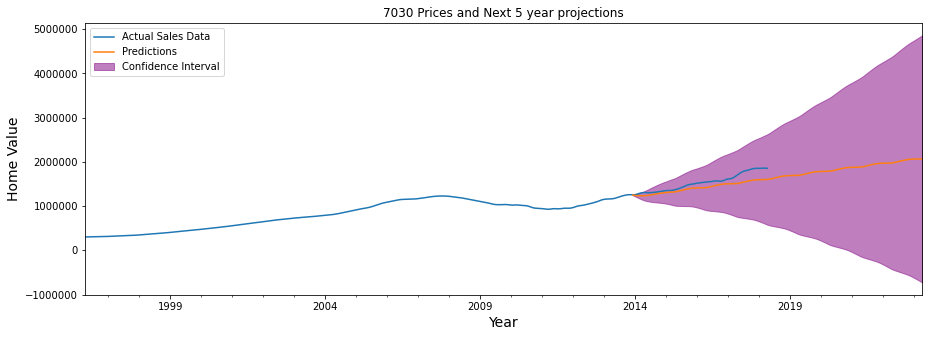

PDQ is (2, 1, 2)
Seasonal PDQ is (1, 1, 2, 12)
7002 Test RMSE: 55167.174
7002 ROI%= -16.8235850189552


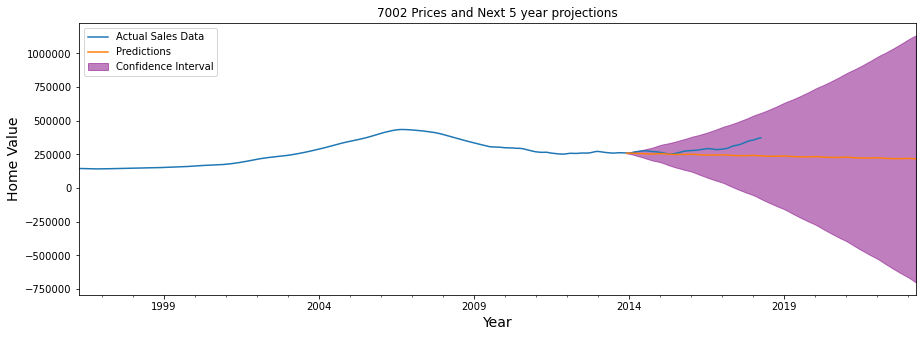

PDQ is (1, 1, 2)
Seasonal PDQ is (0, 1, 2, 12)
7302 Test RMSE: 329429.979
7302 ROI%= 35.07894065874501


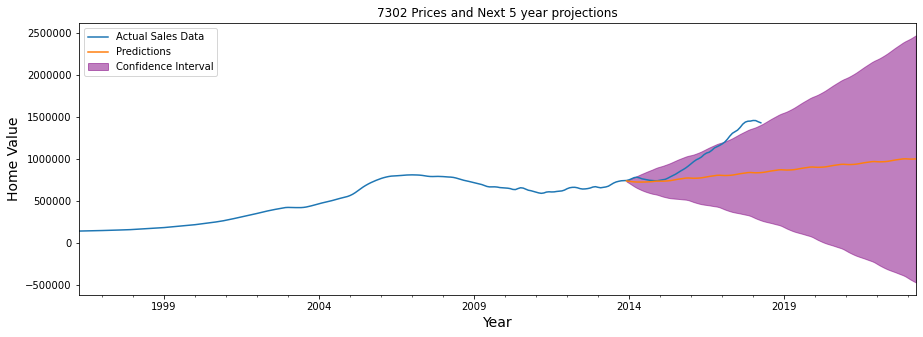

PDQ is (1, 1, 2)
Seasonal PDQ is (0, 1, 2, 12)
7093 Test RMSE: 100467.331
7093 ROI%= -32.350785741948464


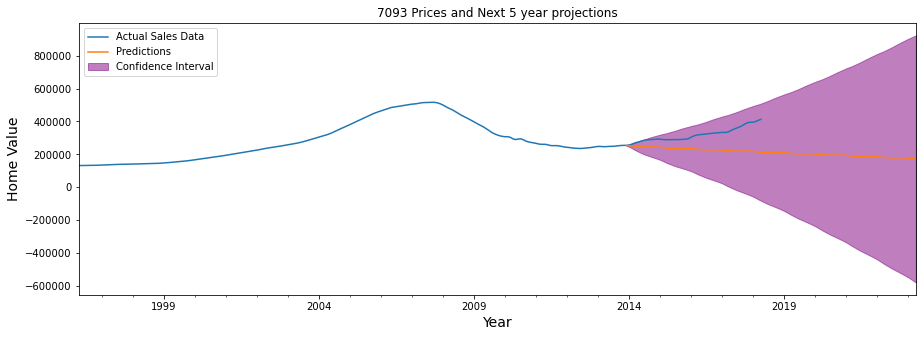

PDQ is (2, 1, 2)
Seasonal PDQ is (1, 1, 2, 12)
7087 Test RMSE: 133367.762
7087 ROI%= -68.05724064865892


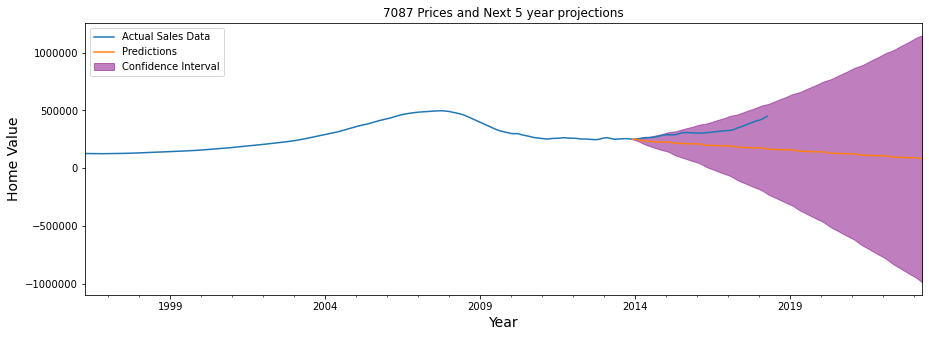

PDQ is (1, 1, 2)
Seasonal PDQ is (0, 1, 2, 12)
7305 Test RMSE: 59955.059
7305 ROI%= -34.44044184456906


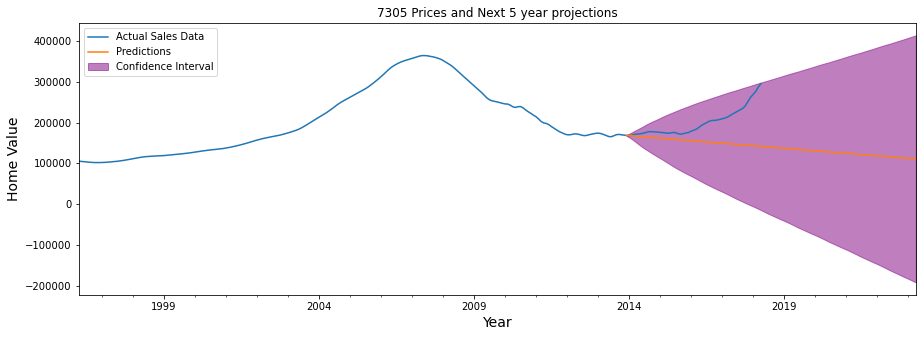

PDQ is (1, 1, 2)
Seasonal PDQ is (0, 1, 2, 12)
7047 Test RMSE: 111580.729
7047 ROI%= -59.30221982100405


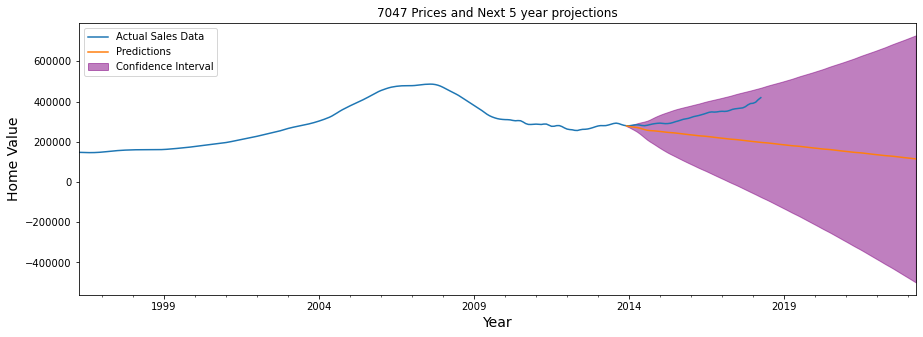

PDQ is (1, 1, 2)
Seasonal PDQ is (0, 1, 2, 12)
7306 Test RMSE: 170350.428
7306 ROI%= -44.52820199649732


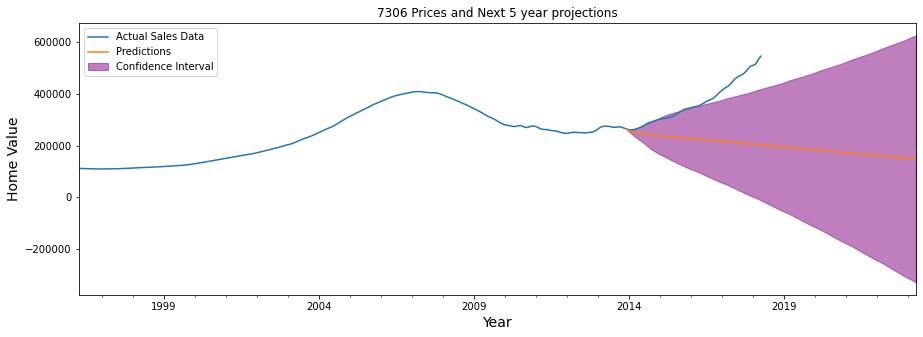

PDQ is (1, 1, 2)
Seasonal PDQ is (1, 1, 2, 12)
7307 Test RMSE: 98342.213
7307 ROI%= 32.50828072813367


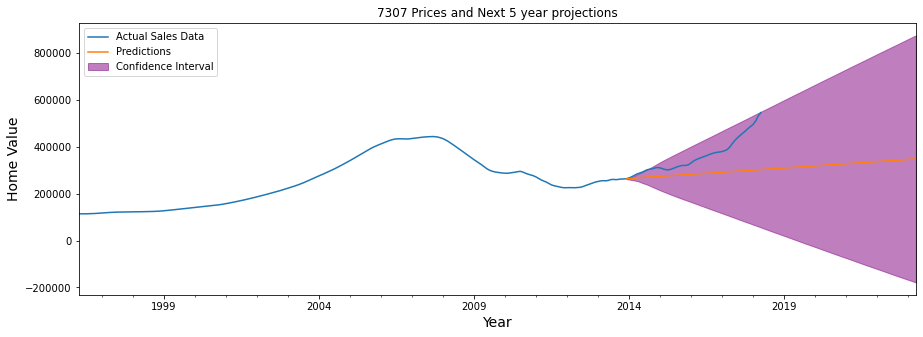

PDQ is (1, 1, 2)
Seasonal PDQ is (0, 1, 2, 12)
7032 Test RMSE: 14682.671
7032 ROI%= 32.61025143519095


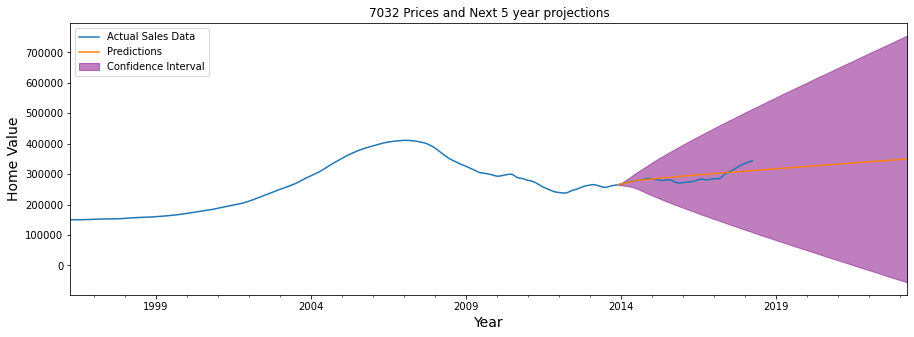

PDQ is (2, 1, 2)
Seasonal PDQ is (0, 1, 2, 12)
7094 Test RMSE: 27444.519
7094 ROI%= 23.759478915376008


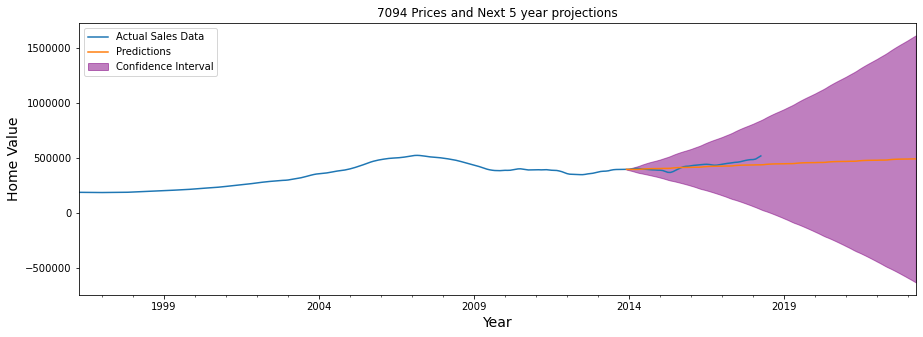

PDQ is (2, 1, 2)
Seasonal PDQ is (2, 1, 2, 12)
7086 Test RMSE: 86213.878
7086 ROI%= 21.83483405635115


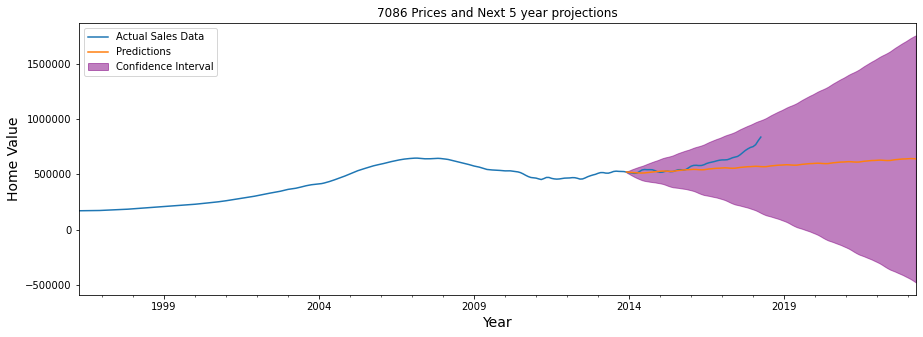

PDQ is (2, 1, 2)
Seasonal PDQ is (0, 1, 2, 12)
7029 Test RMSE: 11651.646
7029 ROI%= 120.99772913796969


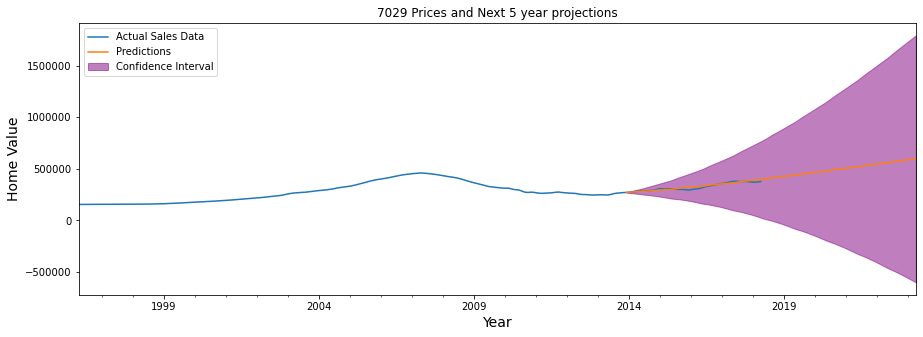

Wall time: 30min 36s


In [34]:
%%time

for x in Suburbs:
    sarimax_model(Suburbs[x])

stop = timeit.default_timer()


In [39]:
ROI_dict_sarimax_2= {7002: -16.8235850189552, 7029: 120.99772913796969, 7030: 64.34021087675617, 7032: 32.61025143519095,
                     7047: -59.30221982100405, 7086: 21.83483405635115, 7087: -68.05724064865892, 7093: -32.350785741948464,
                     7094: 23.759478915376008, 7302: 35.07894065874501, 7305: -34.44044184456906, 7306: -44.52820199649732,
                     7307: 32.50828072813367}
ROI_dict_sarimax_2

{7002: -16.8235850189552,
 7029: 120.99772913796969,
 7030: 64.34021087675617,
 7032: 32.61025143519095,
 7047: -59.30221982100405,
 7086: 21.83483405635115,
 7087: -68.05724064865892,
 7093: -32.350785741948464,
 7094: 23.759478915376008,
 7302: 35.07894065874501,
 7305: -34.44044184456906,
 7306: -44.52820199649732,
 7307: 32.50828072813367}

In [40]:
ROI_dict_sarimax_2

{7002: -16.8235850189552,
 7029: 120.99772913796969,
 7030: 64.34021087675617,
 7032: 32.61025143519095,
 7047: -59.30221982100405,
 7086: 21.83483405635115,
 7087: -68.05724064865892,
 7093: -32.350785741948464,
 7094: 23.759478915376008,
 7302: 35.07894065874501,
 7305: -34.44044184456906,
 7306: -44.52820199649732,
 7307: 32.50828072813367}

In [41]:
from operator import itemgetter, attrgetter
Zip_by_ROI_sarimax= sorted(ROI_dict_sarimax_2.items(), key=itemgetter(1), reverse=True)
top_5_Zip_ROI_sarimax= pd.DataFrame(Zip_by_ROI_sarimax)
top_5_Zip_ROI_sarimax.rename( columns={0 :'Zipcode', 1:'Projected 5 Year ROI%'}, inplace=True )
top_5_Zip_ROI_sarimax

Zipcode  Projected 5 Year ROI%
0      7029             120.997729
1      7030              64.340211
2      7302              35.078941
3      7032              32.610251
4      7307              32.508281
5      7094              23.759479
6      7086              21.834834
7      7002             -16.823585
8      7093             -32.350786
9      7305             -34.440442
10     7306             -44.528202
11     7047             -59.302220
12     7087             -68.057241

In [42]:
top_5_Zip_ROI_sarimax = top_5_Zip_ROI_sarimax.assign(Zipcode= (top_5_Zip_ROI_sarimax['Zipcode'].apply(lambda x: str(x))))
top_5_Zip_ROI_sarimax

Zipcode  Projected 5 Year ROI%
0     7029             120.997729
1     7030              64.340211
2     7302              35.078941
3     7032              32.610251
4     7307              32.508281
5     7094              23.759479
6     7086              21.834834
7     7002             -16.823585
8     7093             -32.350786
9     7305             -34.440442
10    7306             -44.528202
11    7047             -59.302220
12    7087             -68.057241

Ultimately, I would like to map these zip codes and their returns. To do that, I will use a JSON file. The JSON file has the zip codes stored as strings so I  will add a 0 to the zip code name:

In [43]:
#Adding a '0' to my zip code names so they match with the JSON zip code names.
top_5_Zip_ROI_sarimax = top_5_Zip_ROI_sarimax.assign(Zipcode= (top_5_Zip_ROI_sarimax['Zipcode'].apply(lambda x: x.replace('7002', '07002'))))
top_5_Zip_ROI_sarimax = top_5_Zip_ROI_sarimax.assign(Zipcode= (top_5_Zip_ROI_sarimax['Zipcode'].apply(lambda x: x.replace('7029', '07029'))))
top_5_Zip_ROI_sarimax = top_5_Zip_ROI_sarimax.assign(Zipcode= (top_5_Zip_ROI_sarimax['Zipcode'].apply(lambda x: x.replace('7030', '07030'))))
top_5_Zip_ROI_sarimax = top_5_Zip_ROI_sarimax.assign(Zipcode= (top_5_Zip_ROI_sarimax['Zipcode'].apply(lambda x: x.replace('7032', '07032'))))
top_5_Zip_ROI_sarimax = top_5_Zip_ROI_sarimax.assign(Zipcode= (top_5_Zip_ROI_sarimax['Zipcode'].apply(lambda x: x.replace('7047', '07047'))))
top_5_Zip_ROI_sarimax = top_5_Zip_ROI_sarimax.assign(Zipcode= (top_5_Zip_ROI_sarimax['Zipcode'].apply(lambda x: x.replace('7086', '07086'))))
top_5_Zip_ROI_sarimax = top_5_Zip_ROI_sarimax.assign(Zipcode= (top_5_Zip_ROI_sarimax['Zipcode'].apply(lambda x: x.replace('7087', '07087'))))
top_5_Zip_ROI_sarimax = top_5_Zip_ROI_sarimax.assign(Zipcode= (top_5_Zip_ROI_sarimax['Zipcode'].apply(lambda x: x.replace('7093', '07093'))))
top_5_Zip_ROI_sarimax = top_5_Zip_ROI_sarimax.assign(Zipcode= (top_5_Zip_ROI_sarimax['Zipcode'].apply(lambda x: x.replace('7094', '07094'))))
top_5_Zip_ROI_sarimax = top_5_Zip_ROI_sarimax.assign(Zipcode= (top_5_Zip_ROI_sarimax['Zipcode'].apply(lambda x: x.replace('7302', '07302'))))
top_5_Zip_ROI_sarimax = top_5_Zip_ROI_sarimax.assign(Zipcode= (top_5_Zip_ROI_sarimax['Zipcode'].apply(lambda x: x.replace('7305', '07305'))))
top_5_Zip_ROI_sarimax = top_5_Zip_ROI_sarimax.assign(Zipcode= (top_5_Zip_ROI_sarimax['Zipcode'].apply(lambda x: x.replace('7306', '07306'))))
top_5_Zip_ROI_sarimax = top_5_Zip_ROI_sarimax.assign(Zipcode= (top_5_Zip_ROI_sarimax['Zipcode'].apply(lambda x: x.replace('7307', '07307'))))


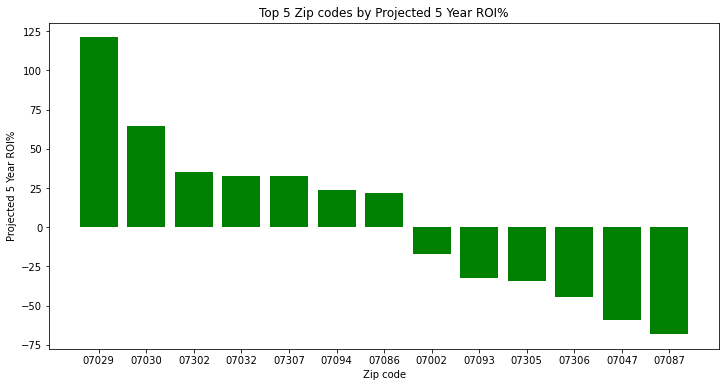

In [44]:
top_5_Zip_ROI_sarimax = top_5_Zip_ROI_sarimax.assign(Zipcode= (top_5_Zip_ROI_sarimax['Zipcode'].apply(lambda x: str(x))))
fig, ax1 = plt.subplots(ncols=1, figsize=(12,6))
ax1.bar(
    x=top_5_Zip_ROI_sarimax['Zipcode'],
    height=top_5_Zip_ROI_sarimax['Projected 5 Year ROI%'], color='green'
)
ax1.set_title("Top 5 Zip codes by Projected 5 Year ROI%")

ax1.set_xlabel("Zip code")
ax1.set_ylabel("Projected 5 Year ROI%");

Ok, so to map the results, I need to their longitudinal and latitudinal coordinates stored in a JSON file. I have my own file but I got the coordinate info from here: https://github.com/OpenDataDE/State-zip-code-GeoJSON

In [45]:
# Importing relevant libraries
import json
import geojson
import folium


In [46]:
import json

codes = open("zipcodes.json", encoding='utf8')


with open("zipcodes.json") as f:
    hudson_codes = json.load(f)

In [76]:
#The map
divisions=[0,0.25,0.5,0.75,1]
quantiles = list(top_5_Zip_ROI_sarimax['Projected 5 Year ROI%'].quantile(divisions))
m = folium.Map(location=[40.7438869,-74.1514239], zoom_start=11)
folium.Choropleth(
    geo_data=hudson_codes,
    data=top_5_Zip_ROI_sarimax,
    columns=['Zipcode', 'Projected 5 Year ROI%'],
    key_on='properties.ZCTA5CE10',
    fill_color='RdYlGn',
    fill_opacity=0.9,
    line_opacity=0.9,
    bins=quantiles,
    
).add_to(m)
m

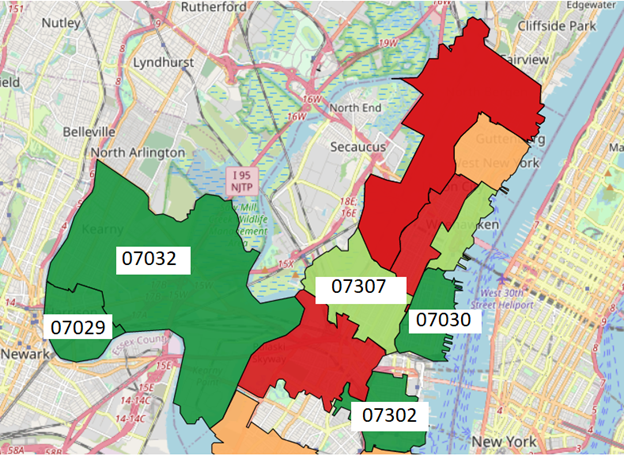

No.1, at 121%, is 07029. This zipcode is in Harrison, NJ and East Newark, NJ.

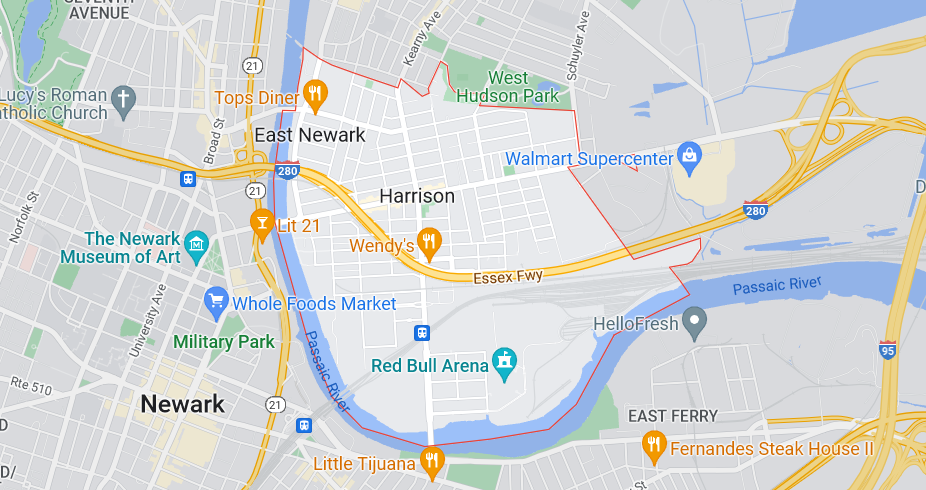

No. 2, at 64%, is 07030. This zip code is in Hoboken, NJ .

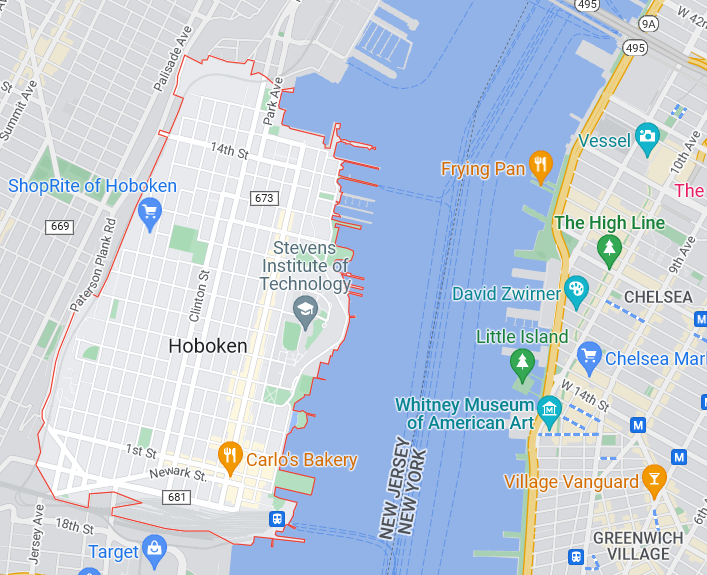

No. 3, at 35%, is 07302. This zip code is in Jersey City, NJ. 

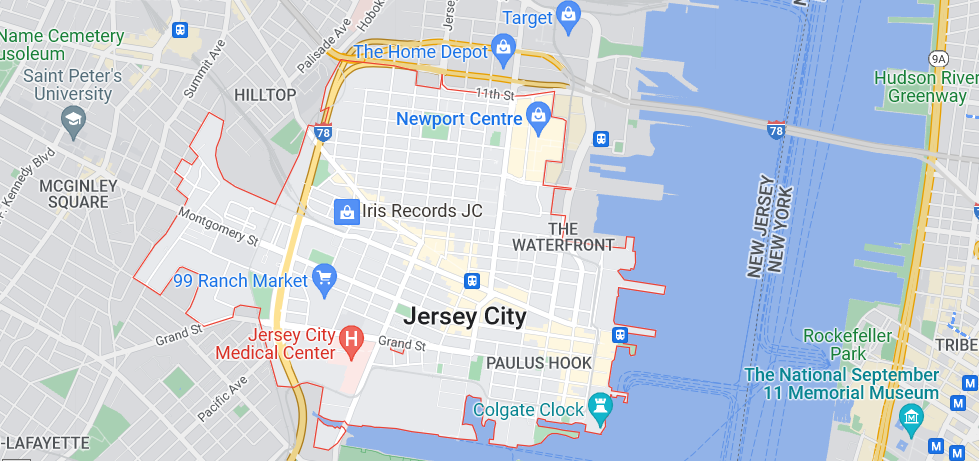

No. 4, at 32.6%,  is 07032. This zip code includes part of Kearny, NJ, Jersey City, NJ, Secaucus, NJ, and Lyndhurst, NJ.

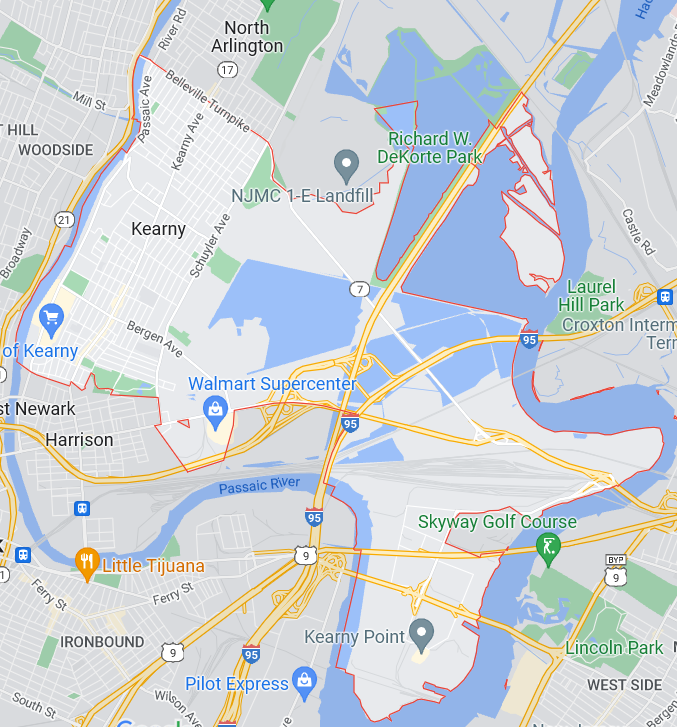


No. 5, at 32.5%, is 07307. This zip code is in Jersey City, NJ.

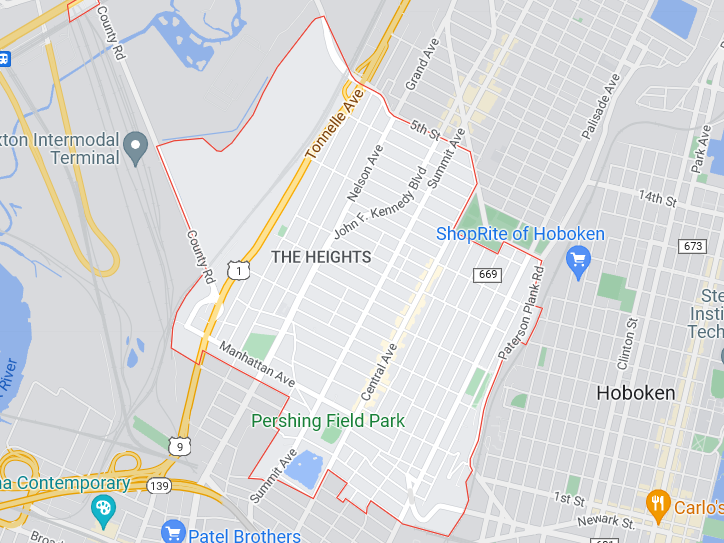

# CONCLUSION

According to the model, **the top 5 zip codes with the highest ROI% from May 2018 to March 2023 were 07029, 07030, 07302, 07032, 07307. I recommend that investors target those 5 zip codes. Moreover, if they are looking to purchase homes under 500k then they should target 07029 and 07032**. The RMSEs are much improved from the auto.arima model and are quite low for some of the zip codes. However, the confidence intervals for each zip code prediction are very large. In all of the zip codes, the confidence intervals veer into negative $ amounts. 

However, there may be meaningful reasons for the large confidence intervals.The wide confidence intervals are a product of either a small sample or a large degree of variation in the data. I cannot say whether the sample was big enough but the graphs of the prices suggest that the data has a high degree of variation. For each zip code in the dataset, there is a fall around the time of the Great Financial Crisis or GFC(circa 2008). The values start to rise again in 2011 and either stabilize or continue to increase. While I could I have used a truncated dataset that began after the GFC, I decided to include the GFC and pre-GFC data because this area is very tied to Wall Street so omitting that data would be doing investors a disservice. 

# NEXT STEPS
- An updated dataset that extends to 2022 would obviously be useful and would possibly generate more accurate predictions. It would also be interesting to see how a model would account for the COVID pandemic.
- More data on 07304 would also be very useful to investors and to the model. Unfortunately, the Zillow dataset omitted this zip code. 
- Lastly, another ML model may yield more fruitful results. An XGBoost Regressor or a neural network model may yield better and more meaningful results.